## Переобучение нейронных сетей и борьба с ним

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________


def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_info = {}
        layer_name, params = layer_str.split("(", 1)
        params = params.rstrip(")")
        layer_info["type"] = layer_name.strip()
        param_dict = {}
        for param in params.split(", "):
            if "=" in param:
                key, value = param.split("=")
                param_dict[key.strip()] = eval(value.strip())
            else:
                param_dict[param.strip()] = None
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict


# __________end of block__________

In [3]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [ ]:
# !wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict.npy

In [5]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Задача №1: Создание и обучение модели (Separation)
Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [6]:
CUDA_DEVICE_ID = 0  # change if needed

In [7]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.4MB/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Text(0.5, 1.0, 'Image label: 1')

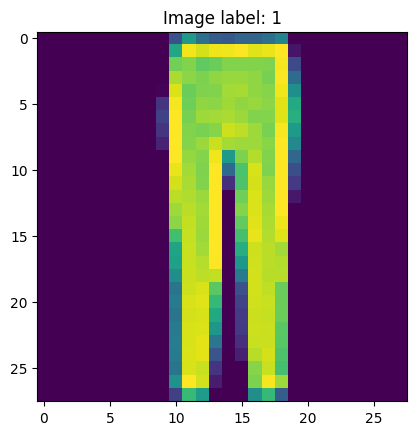

In [8]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [9]:
classes = len(train_fmnist_data.classes)
classes

10

In [10]:
img_size = train_fmnist_data.data[0].unsqueeze(0).shape
img_size

torch.Size([1, 28, 28])

In [11]:
from typing import OrderedDict
# Creating model instance

class residual_block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, activation, dropout_p, pool, i):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            (f'conv', nn.Conv2d(in_c, out_c, kernel_size, padding="same")),
            (f'bnorm', nn.BatchNorm2d(out_c)),
            (f'drop', nn.Dropout2d(dropout_p)),
            (f'act', activation),
        ]))
        self.pool = pool
        self.i = i
        if in_c != out_c and self.i:
            self.conv1 = nn.Conv2d(in_c, out_c, 1)
        else:
            self.conv1 = nn.Identity()

    def forward(self, x):
        if self.i:
            return self.pool(self.conv1(x) + self.block(x))
        else:
            return self.pool(self.block(x))

class FashionMNISTModel(nn.Module):
    def __init__(
        self,
        input_size,
        num_conv_layers,
        kernel_sizes,
        hidden_size,
        activations,
        dropouts,
        poolings,
        output_size
    ):
        super(FashionMNISTModel, self).__init__()


        if not isinstance(kernel_sizes, list):
            kernel_sizes = [kernel_sizes] * num_conv_layers
        assert len(kernel_sizes) == num_conv_layers, f'provide {num_conv_layers} kernel_sizes or just one for all layers'

        assert isinstance(hidden_size, int), f'provide one hidden_size for all layers'
        hidden_sizes = [input_size[0]] + [hidden_size] * num_conv_layers

        if not isinstance(activations, list):
            activations = [activations] * num_conv_layers
        assert len(activations) == num_conv_layers, f'provide {num_conv_layers} activation functions or just one for all layers'

        if not isinstance(dropouts, list):
            dropouts = [dropouts] * num_conv_layers
        assert len(dropouts) == num_conv_layers, f'provide {num_conv_layers} dropout values or just one for all layers'

        if not isinstance(poolings, list):
            poolings = [poolings] * num_conv_layers
        assert len(poolings) == num_conv_layers, f'provide {num_conv_layers} poolings or just one for all layers'
        available_poolings = {None, nn.MaxPool2d, nn.AvgPool2d, nn.Identity}
        assert np.sum([poolings[i] in available_poolings for i in range(num_conv_layers)]) == num_conv_layers, \
               f'each pooling should be one of {available_poolings}'

        self.poolings = [poolings[i](2) if poolings[i] else nn.Identity() for i in range(num_conv_layers)]

        self.conv_block = nn.Sequential(OrderedDict([
            (f'conv0', nn.Conv2d(in_channels=input_size[0], out_channels=hidden_sizes[0], kernel_size=3)),
            (f'bn0', nn.BatchNorm2d(hidden_sizes[0])),
            (f'activ0', nn.LeakyReLU(0.2)),
        ]))
        self.layers = nn.Sequential(OrderedDict(
            [
                (f'block{i}', residual_block(
                    hidden_sizes[i],
                    hidden_sizes[i + 1],
                    kernel_sizes[i],
                    activations[i],
                    dropouts[i],
                    self.poolings[i],
                    i
                )) for i in range(num_conv_layers)
            ]
        ))
        self.head = nn.Sequential(OrderedDict([
            (f'flatten', nn.Flatten()),
            (f'hid2out', nn.Linear(hidden_sizes[-1] * 3 * 3, output_size)),
            (f'log_softmax', nn.LogSoftmax(dim=-1)),
        ]))
        # self.net = nn.Sequential(*[self.conv_block, self.layers, self.head])

    def forward(self, x):
        # return self.net(x)
        out = self.conv_block(x)
        out = self.layers(out)
        out = self.head(out)
        return out




model_task_1 = FashionMNISTModel(
    input_size = img_size,
    num_conv_layers = 3,
    kernel_sizes = 3,
    hidden_size = 32,
    activations = nn.LeakyReLU(0.2),
    dropouts = 0.2,
    poolings = nn.AvgPool2d,
    output_size = classes
)
# your code here

Не забудьте перенести модель на выбранный `device`!

In [12]:
model_task_1.to(device)

FashionMNISTModel(
  (conv_block): Sequential(
    (conv0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (bn0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ0): LeakyReLU(negative_slope=0.2)
  )
  (layers): Sequential(
    (block0): residual_block(
      (block): Sequential(
        (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout2d(p=0.2, inplace=False)
        (act): LeakyReLU(negative_slope=0.2)
      )
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (conv1): Identity()
    )
    (block1): residual_block(
      (block): Sequential(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout2d(p=0.2, inplace=False)
        (act): LeakyRe

Локальные тесты для проверки вашей модели доступны ниже:

In [13]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [41]:
import IPython
from math import ceil

def train_loop(model, dataloader, optim, loss_fn, scheduler=None, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)
    model.train()

    train_loss, train_acc = [], []

    size = len(dataloader.dataset)
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1

    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc='Batch #')):
        X = X.to(device)
        y = y.to(device)

        preds = model(X)
        loss = loss_fn(preds, y)
        train_loss.append(loss.item())
        acc = (preds.argmax(1) == y).type(torch.float).sum().item()
        train_acc.append(acc / y.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch == batches:
            out.update(f'[Acc: {np.mean(train_acc)} Loss: {np.mean(train_loss):>8f}')
    if scheduler:
        try:
            scheduler.step()
        except:
            scheduler.step(loss)

    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}

def eval_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):
    model.eval()

    val_loss, val_acc = [], []

    size = len(dataloader.dataset)
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1

    with torch.no_grad():
        for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc='Batch #')):
            X = X.to(device)
            y = y.to(device)

            preds = model(X)
            loss = loss_fn(preds, y)
            val_loss.append(loss.item())
            acc = (preds.argmax(1) == y).type(torch.float).sum().item()
            val_acc.append(acc / y.size(0))

    print(f"Validation accuracy: {(100*np.mean(val_acc)):>0.1f}%, Validation loss: {np.mean(val_loss):>8f} \n")

    if history_loss is not None:
        history_loss.append(np.mean(val_loss))
    if history_acc is not None:
        history_acc.append(np.mean(val_acc))

    return {'val_loss': np.mean(val_loss), 'val_acc': np.mean(val_acc)}

In [15]:
def plot_learning_process(train_loss, train_acc, val_loss, val_acc):

    fig = plt.figure(figsize=(12, 4))

    ax1 = plt.subplot(121)
    ax1.set_title('loss by epoch')
    ax1.plot(np.arange(0, len(train_loss)) + 0.5, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss function')

    ax2 = plt.subplot(122)
    ax2.set_title('accuracy by epoch')
    ax2.plot(np.arange(0, len(train_acc)) + 0.5, train_acc, label='train')
    ax2.plot(np.arange(0, len(val_acc)) + 1, val_acc, label='val')
    ax2.legend()
    ax2.grid()
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')

    fig.tight_layout()
    plt.show()

Epoch 1
-------------------------------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


'[Acc: 0.90625 Loss: 0.356065'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 93.8%, Validation loss: 0.226254 

Epoch 2
-------------------------------


'[Acc: 0.9375 Loss: 0.290510'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.5%, Validation loss: 0.220381 

Epoch 3
-------------------------------


'[Acc: 0.9375 Loss: 0.193915'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.5%, Validation loss: 0.185069 

Epoch 4
-------------------------------


'[Acc: 0.90625 Loss: 0.183036'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 93.8%, Validation loss: 0.201323 

Epoch 5
-------------------------------


'[Acc: 0.875 Loss: 0.277998'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 100.0%, Validation loss: 0.144457 

Epoch 6
-------------------------------


'[Acc: 0.96875 Loss: 0.226194'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 93.8%, Validation loss: 0.203886 

Epoch 7
-------------------------------


'[Acc: 0.84375 Loss: 0.497000'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.5%, Validation loss: 0.210823 

Epoch 8
-------------------------------


'[Acc: 0.96875 Loss: 0.112558'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 93.8%, Validation loss: 0.150647 

Epoch 9
-------------------------------


'[Acc: 0.9375 Loss: 0.133190'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 93.8%, Validation loss: 0.190844 

Epoch 10
-------------------------------


'[Acc: 0.96875 Loss: 0.166245'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.5%, Validation loss: 0.189019 

Epoch 11
-------------------------------


'[Acc: 0.96875 Loss: 0.170371'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 100.0%, Validation loss: 0.143509 

Epoch 12
-------------------------------


'[Acc: 0.875 Loss: 0.256275'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 100.0%, Validation loss: 0.176343 

Epoch 13
-------------------------------


'[Acc: 0.84375 Loss: 0.281343'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 93.8%, Validation loss: 0.198523 

Epoch 14
-------------------------------


'[Acc: 0.96875 Loss: 0.155398'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 93.8%, Validation loss: 0.189855 

Epoch 15
-------------------------------


'[Acc: 0.84375 Loss: 0.469444'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 93.8%, Validation loss: 0.185100 



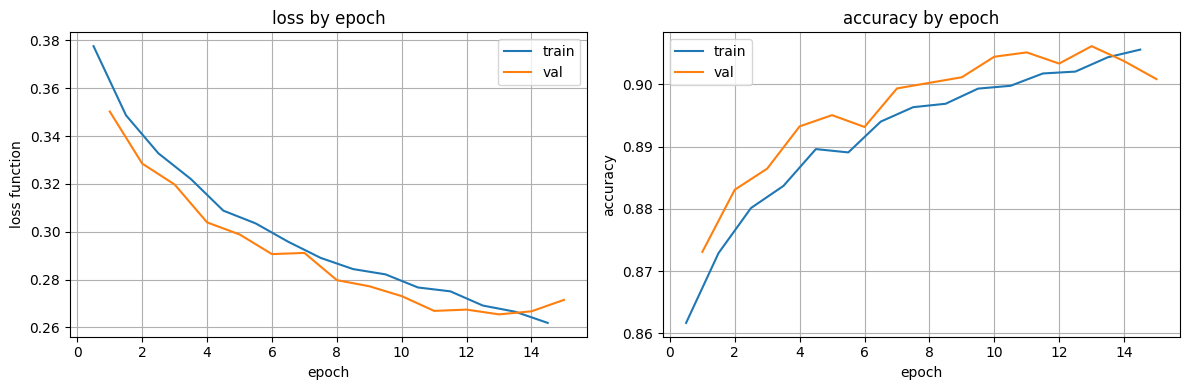

In [18]:
from tqdm.notebook import tqdm
model = model_task_1
loss_fn = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(model.parameters(), 1e-3, [0.9, 0.999])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=50,
    verbose=True,
)
epochs = 15

train_loss, train_acc, train_lr = [], [], []
val_loss, val_acc = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(model, train_data_loader, optimizer, loss_fn, scheduler, history_loss=train_loss, history_acc=train_acc)
    eval_loop(model, test_data_loader, loss_fn, history_loss=val_loss, history_acc=val_acc)
    for param_group in optimizer.param_groups:
        train_lr.append(param_group['lr'])
plot_learning_process(train_loss, train_acc, val_loss, val_acc)

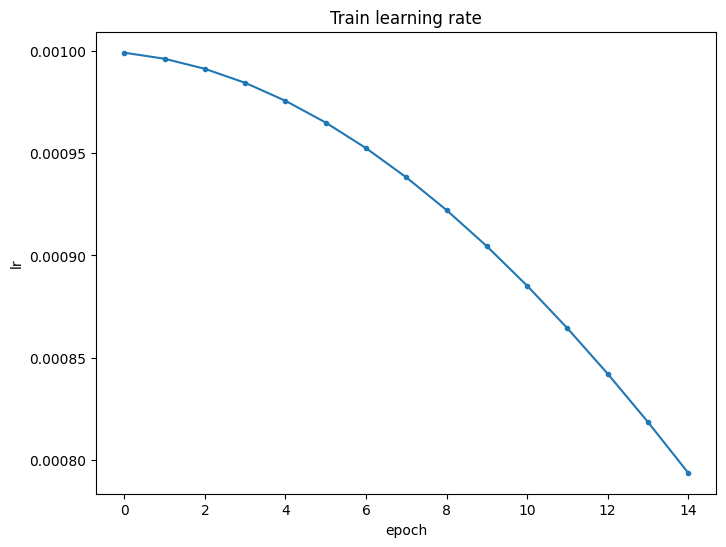

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(train_lr,  '.-', label='lr')
plt.title('Train learning rate')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.show()

In [24]:
# torch.save(model.state_dict(), 'model_params.pth')

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [25]:
# model_task_1.load_state_dict(torch.load('model_params.pth', map_location=torch.device('cpu'), weights_only=True))

In [26]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.91527


In [27]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9008


Проверка, что необходимые пороги пройдены:

In [28]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель содержится в переменной `model_task_1`.

In [29]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


### Задача №2: Переобучение (Initiation)
Продолжим работу с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Теперь ваша задача продемонстрировать переобучение модели на обучающей выборке. Достаточно показать, что точность классификации (не только функция потерь!) на тестовой выборке значительно отстает от обучающей.

Обращаем ваше внимание, в задаче №3 вам придется починить данную модель (минимизировать эффект переобучения) с помощью механизмов регуляризации, поэтому не переусердствуйте!

__Ваша вторая задача: реализовать используя пайплан обучения модели продемонстрировать переобучения модели на обучающей выборке.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_2` для хранение модели во второй задаче.

Не используйте `Dropout` и `BatchNorm` в этой задаче

In [38]:
from typing import OrderedDict
# Creating model instance

class residual_block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, activation, pool, i):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            (f'conv', nn.Conv2d(in_c, out_c, kernel_size, padding="same")),
            (f'act', activation),
        ]))
        self.pool = pool
        self.i = i
        if in_c != out_c and self.i:
            self.conv1 = nn.Conv2d(in_c, out_c, 1)
        else:
            self.conv1 = nn.Identity()

    def forward(self, x):
        if self.i:
            return self.pool(self.conv1(x) + self.block(x))
        else:
            return self.pool(self.block(x))

class FashionMNISTModel(nn.Module):
    def __init__(
        self,
        input_size,
        num_conv_layers,
        kernel_sizes,
        hidden_size,
        activations,
        poolings,
        output_size
    ):
        super(FashionMNISTModel, self).__init__()


        if not isinstance(kernel_sizes, list):
            kernel_sizes = [kernel_sizes] * num_conv_layers
        assert len(kernel_sizes) == num_conv_layers, f'provide {num_conv_layers} kernel_sizes or just one for all layers'

        assert isinstance(hidden_size, int), f'provide one hidden_size for all layers'
        hidden_sizes = [input_size[0]] + [hidden_size] * num_conv_layers

        if not isinstance(activations, list):
            activations = [activations] * num_conv_layers
        assert len(activations) == num_conv_layers, f'provide {num_conv_layers} activation functions or just one for all layers'

        if not isinstance(poolings, list):
            poolings = [poolings] * num_conv_layers
        assert len(poolings) == num_conv_layers, f'provide {num_conv_layers} poolings or just one for all layers'
        available_poolings = {None, nn.MaxPool2d, nn.AvgPool2d, nn.Identity}
        assert np.sum([poolings[i] in available_poolings for i in range(num_conv_layers)]) == num_conv_layers, \
               f'each pooling should be one of {available_poolings}'

        self.poolings = [poolings[i](2) if poolings[i] else nn.Identity() for i in range(num_conv_layers)]

        self.conv_block = nn.Sequential(OrderedDict([
            (f'conv0', nn.Conv2d(in_channels=input_size[0], out_channels=hidden_sizes[0], kernel_size=3)),
            (f'activ0', nn.LeakyReLU(0.2)),
        ]))
        self.layers = nn.Sequential(OrderedDict(
            [
                (f'block{i}', residual_block(
                    hidden_sizes[i],
                    hidden_sizes[i + 1],
                    kernel_sizes[i],
                    activations[i],
                    self.poolings[i],
                    i
                )) for i in range(num_conv_layers)
            ]
        ))
        self.head = nn.Sequential(OrderedDict([
            (f'flatten', nn.Flatten()),
            (f'hid2out', nn.Linear(hidden_sizes[-1] * 6 * 6, output_size)),
            (f'hid2out2', nn.Linear(output_size, output_size)),
            (f'log_softmax', nn.LogSoftmax(dim=-1)),
        ]))

    def forward(self, x):
        out = self.conv_block(x)
        out = self.layers(out)
        out = self.head(out)
        return out
# your code here

In [39]:
# Creating model instance
model_task_2 = FashionMNISTModel(
    input_size = img_size,
    num_conv_layers = 2,
    kernel_sizes = 3,
    hidden_size = 64,
    activations = nn.LeakyReLU(0.2),
    poolings = nn.AvgPool2d,
    output_size = classes
)
# your code here

Epoch 1
-------------------------------


'[Acc: 0.8036333333333333 Loss: 0.543797'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 84.8%, Validation loss: 0.426286 

Epoch 2
-------------------------------


'[Acc: 0.86045 Loss: 0.389667'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 85.1%, Validation loss: 0.421568 

Epoch 3
-------------------------------


'[Acc: 0.8674 Loss: 0.367045'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.0%, Validation loss: 0.366678 

Epoch 4
-------------------------------


'[Acc: 0.8733333333333333 Loss: 0.354376'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 86.3%, Validation loss: 0.391819 

Epoch 5
-------------------------------


'[Acc: 0.8820666666666667 Loss: 0.328840'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 86.4%, Validation loss: 0.407228 

Epoch 6
-------------------------------


'[Acc: 0.8827833333333334 Loss: 0.328469'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.2%, Validation loss: 0.370350 

Epoch 7
-------------------------------


'[Acc: 0.8879 Loss: 0.317845'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 86.7%, Validation loss: 0.443621 

Epoch 8
-------------------------------


'[Acc: 0.8895 Loss: 0.315732'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 85.3%, Validation loss: 0.408336 

Epoch 9
-------------------------------


'[Acc: 0.8910666666666667 Loss: 0.309223'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 88.8%, Validation loss: 0.332145 

Epoch 10
-------------------------------


'[Acc: 0.8926166666666666 Loss: 0.301818'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 86.9%, Validation loss: 0.391576 

Epoch 11
-------------------------------


'[Acc: 0.8963666666666666 Loss: 0.295801'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 85.7%, Validation loss: 0.437212 

Epoch 12
-------------------------------


'[Acc: 0.8965833333333333 Loss: 0.298402'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.8%, Validation loss: 0.358950 

Epoch 13
-------------------------------


'[Acc: 0.8967666666666667 Loss: 0.290335'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 88.5%, Validation loss: 0.359991 

Epoch 14
-------------------------------


'[Acc: 0.8980666666666667 Loss: 0.294569'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.9%, Validation loss: 0.416482 

Epoch 15
-------------------------------


'[Acc: 0.89985 Loss: 0.283437'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 88.4%, Validation loss: 0.353965 

Epoch 16
-------------------------------


'[Acc: 0.8987333333333334 Loss: 0.286399'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 88.0%, Validation loss: 0.359399 

Epoch 17
-------------------------------


'[Acc: 0.8992 Loss: 0.289962'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.8%, Validation loss: 0.398281 

Epoch 18
-------------------------------


'[Acc: 0.9006666666666666 Loss: 0.285762'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 88.7%, Validation loss: 0.344985 

Epoch 19
-------------------------------


'[Acc: 0.9024333333333333 Loss: 0.279242'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 85.6%, Validation loss: 0.476217 

Epoch 20
-------------------------------


'[Acc: 0.9003666666666666 Loss: 0.283579'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 86.5%, Validation loss: 0.403615 

Epoch 21
-------------------------------


'[Acc: 0.9038 Loss: 0.280040'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 88.8%, Validation loss: 0.348720 

Epoch 22
-------------------------------


'[Acc: 0.9025166666666666 Loss: 0.282223'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 86.9%, Validation loss: 0.480159 

Epoch 23
-------------------------------


'[Acc: 0.9044 Loss: 0.274623'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.7%, Validation loss: 0.410980 

Epoch 24
-------------------------------


'[Acc: 0.90645 Loss: 0.272997'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.8%, Validation loss: 0.386742 

Epoch 25
-------------------------------


'[Acc: 0.9056166666666666 Loss: 0.273959'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.1%, Validation loss: 0.413701 



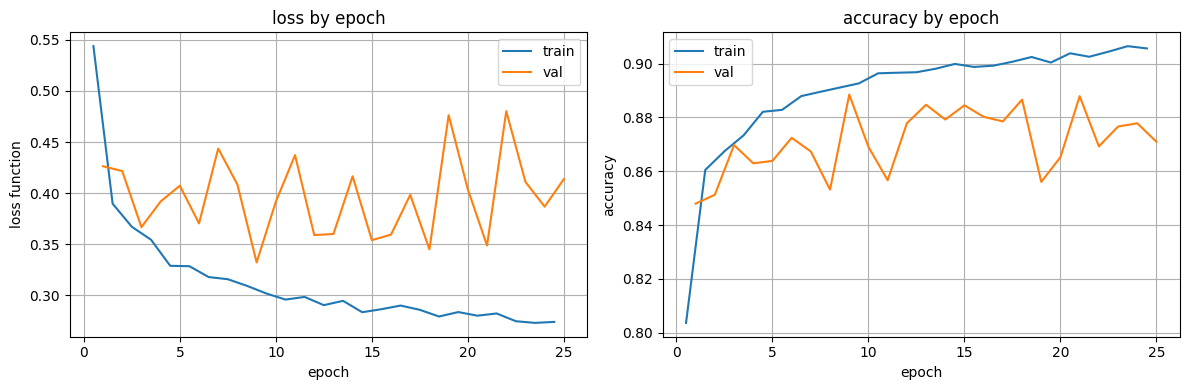

In [42]:
from tqdm.notebook import tqdm
model = model_task_2
model.to(device)
loss_fn = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(model.parameters(), 1e-2, [0.9, 0.999])
epochs = 25

train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(model, train_data_loader, optimizer, loss_fn, history_loss=train_loss, history_acc=train_acc)
    eval_loop(model, test_data_loader, loss_fn, history_loss=val_loss, history_acc=val_acc)
plot_learning_process(train_loss, train_acc, val_loss, val_acc)

Проверка архитектуры:

In [43]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(str(model_task_2)).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

Оценим качество классификации:

In [44]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.91282


In [45]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.8708


Проверка, что переобучение присутствует:

In [46]:
train_acc_task_2 - test_acc_task_2

tensor(0.0420)

In [47]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

Обращаем внимане, код ниже предполагает, что ваша модель содержится в переменной `model_task_2`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задачи №1. Если их там нет, загрузите их из сохраненного файла в переменную перед запуском следующей ячейки.

In [48]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict"
), "Please, download `hw_overfitting_data_dict` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(str(model_task_2)),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Задача №3: Исправление модели (Return)
Все так же работаем с [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Наконец, ваша задача исправить ~~ошибки прошлого~~ переобучение модели, построенной в задаче 2. Достаточно добиться расхождения между точностью классификации на обучающей и тестовой выборках не превышающего 0.015 (т.е. полутора процентов).

Обращаем ваше внимание, архитектура модели в задаче №3 не должна существенно отличаться от задачи №2! Вы можете использовать Batchnorm, Dropout, уменьшить размерность промежуточных представлений, обратиться к аугментации данных, но вы не можете использовать меньшее количество слоёв.

__Ваша третья и финальная задача: исправить модель и/или процесс обучения, дабы справиться с переобучением.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_3` для хранение модели во второй задаче.

Также код ниже будет обращаться к переменной `layers_task_2`, инициализируйте её, если она не определена.

In [49]:
from typing import OrderedDict
# Creating model instance

class residual_block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, activation, dropout_p, pool, i):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            (f'conv', nn.Conv2d(in_c, out_c, kernel_size, padding="same")),
            (f'bnorm', nn.BatchNorm2d(out_c)),
            (f'drop', nn.Dropout2d(dropout_p)),
            (f'act', activation),
        ]))
        self.pool = pool
        self.i = i
        if in_c != out_c and self.i:
            self.conv1 = nn.Conv2d(in_c, out_c, 1)
        else:
            self.conv1 = nn.Identity()

    def forward(self, x):
        if self.i:
            return self.pool(self.conv1(x) + self.block(x))
        else:
            return self.pool(self.block(x))

class FashionMNISTModel(nn.Module):
    def __init__(
        self,
        input_size,
        num_conv_layers,
        kernel_sizes,
        hidden_size,
        activations,
        dropouts,
        poolings,
        output_size
    ):
        super(FashionMNISTModel, self).__init__()


        if not isinstance(kernel_sizes, list):
            kernel_sizes = [kernel_sizes] * num_conv_layers
        assert len(kernel_sizes) == num_conv_layers, f'provide {num_conv_layers} kernel_sizes or just one for all layers'

        assert isinstance(hidden_size, int), f'provide one hidden_size for all layers'
        hidden_sizes = [input_size[0]] + [hidden_size] * num_conv_layers

        if not isinstance(activations, list):
            activations = [activations] * num_conv_layers
        assert len(activations) == num_conv_layers, f'provide {num_conv_layers} activation functions or just one for all layers'

        if not isinstance(dropouts, list):
            dropouts = [dropouts] * num_conv_layers
        assert len(dropouts) == num_conv_layers, f'provide {num_conv_layers} dropout values or just one for all layers'

        if not isinstance(poolings, list):
            poolings = [poolings] * num_conv_layers
        assert len(poolings) == num_conv_layers, f'provide {num_conv_layers} poolings or just one for all layers'
        available_poolings = {None, nn.MaxPool2d, nn.AvgPool2d, nn.Identity}
        assert np.sum([poolings[i] in available_poolings for i in range(num_conv_layers)]) == num_conv_layers, \
               f'each pooling should be one of {available_poolings}'

        self.poolings = [poolings[i](2) if poolings[i] else nn.Identity() for i in range(num_conv_layers)]

        self.conv_block = nn.Sequential(OrderedDict([
            (f'conv0', nn.Conv2d(in_channels=input_size[0], out_channels=hidden_sizes[0], kernel_size=3)),
            (f'bn0', nn.BatchNorm2d(hidden_sizes[0])),
            (f'activ0', nn.LeakyReLU(0.2)),
        ]))
        self.layers = nn.Sequential(OrderedDict(
            [
                (f'block{i}', residual_block(
                    hidden_sizes[i],
                    hidden_sizes[i + 1],
                    kernel_sizes[i],
                    activations[i],
                    dropouts[i],
                    self.poolings[i],
                    i
                )) for i in range(num_conv_layers)
            ]
        ))
        self.head = nn.Sequential(OrderedDict([
            (f'flatten', nn.Flatten()),
            (f'hid2out', nn.Linear(hidden_sizes[-1] * 3 * 3, output_size)),
            (f'log_softmax', nn.LogSoftmax(dim=-1)),
        ]))
        # self.net = nn.Sequential(*[self.conv_block, self.layers, self.head])

    def forward(self, x):
        # return self.net(x)
        out = self.conv_block(x)
        out = self.layers(out)
        out = self.head(out)
        return out

In [94]:
model_task_3 = FashionMNISTModel(
    input_size = img_size,
    num_conv_layers = 3,
    kernel_sizes = 3,
    hidden_size = 64,
    activations = nn.LeakyReLU(0.2),
    dropouts = 0.2,
    poolings = nn.AvgPool2d,
    output_size = classes
)
# your code here

In [95]:
model_task_3.to(device)

FashionMNISTModel(
  (conv_block): Sequential(
    (conv0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (bn0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ0): LeakyReLU(negative_slope=0.2)
  )
  (layers): Sequential(
    (block0): residual_block(
      (block): Sequential(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout2d(p=0.2, inplace=False)
        (act): LeakyReLU(negative_slope=0.2)
      )
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (conv1): Identity()
    )
    (block1): residual_block(
      (block): Sequential(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout2d(p=0.2, inplace=False)
        (act): LeakyRe

In [96]:
# do not change the code in the block below
# __________start of block__________
assert (
    layers_task_2 is not None
), "Initializa layers_task_2 vairable which contains list of layers in task 2 model"
# __________end of block__________

Проверка архитектуры:

In [97]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(str(model_task_3)).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

Epoch 1
-------------------------------


'[Acc: 0.7425833333333334 Loss: 0.759251'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 82.4%, Validation loss: 0.506392 

Epoch 2
-------------------------------


'[Acc: 0.83455 Loss: 0.470872'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 85.3%, Validation loss: 0.414823 

Epoch 3
-------------------------------


'[Acc: 0.8575166666666667 Loss: 0.406275'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 86.7%, Validation loss: 0.375925 

Epoch 4
-------------------------------


'[Acc: 0.8682333333333333 Loss: 0.373163'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 87.1%, Validation loss: 0.360065 

Epoch 5
-------------------------------


'[Acc: 0.8765 Loss: 0.350208'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 88.2%, Validation loss: 0.330650 

Epoch 6
-------------------------------


'[Acc: 0.88205 Loss: 0.332359'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 88.2%, Validation loss: 0.325000 

Epoch 7
-------------------------------


'[Acc: 0.8875333333333333 Loss: 0.320512'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 89.2%, Validation loss: 0.308767 

Epoch 8
-------------------------------


'[Acc: 0.8902666666666667 Loss: 0.308701'

Batch #:   0%|          | 0/1875 [00:00<?, ?it/s]

Batch #:   0%|          | 0/313 [00:00<?, ?it/s]

Validation accuracy: 89.2%, Validation loss: 0.302572 



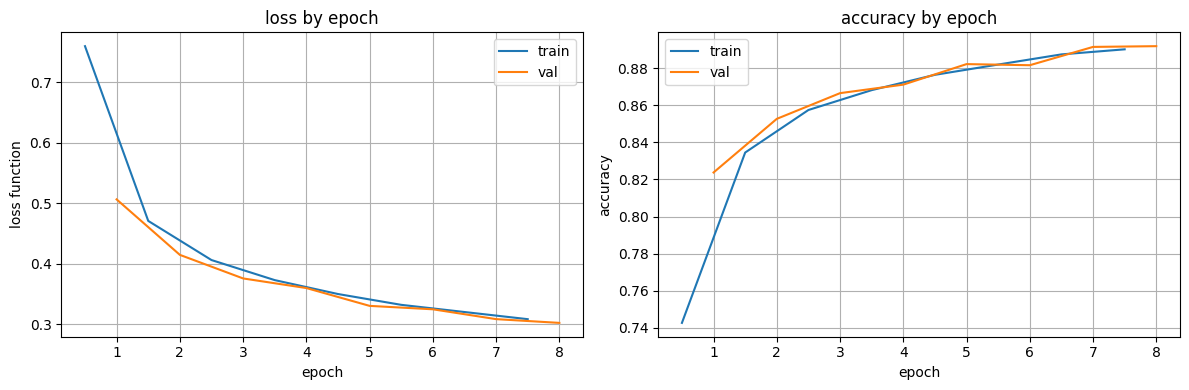

In [98]:
from tqdm.notebook import tqdm
model = model_task_3
loss_fn = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(model.parameters(), 1e-4, [0.9, 0.999])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=50,
    verbose=True,
)
epochs = 8

train_loss, train_acc, train_lr = [], [], []
val_loss, val_acc = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(model, train_data_loader, optimizer, loss_fn, scheduler, history_loss=train_loss, history_acc=train_acc)
    eval_loop(model, test_data_loader, loss_fn, history_loss=val_loss, history_acc=val_acc)
    for param_group in optimizer.param_groups:
        train_lr.append(param_group['lr'])
plot_learning_process(train_loss, train_acc, val_loss, val_acc)

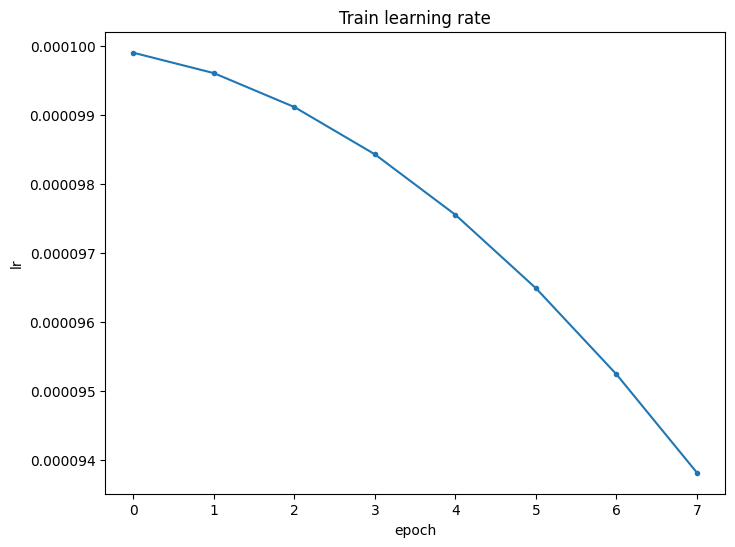

In [99]:
plt.figure(figsize=(8, 6))
plt.plot(train_lr,  '.-', label='lr')
plt.title('Train learning rate')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.show()

Оценим качество классификации:

In [100]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.90272


In [101]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.8921


In [102]:
train_acc_task_3 - test_acc_task_3

tensor(0.0106)

Проверка, что переобучение отсутствует:

In [103]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert train_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_3`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задач №1 и №2. Если их там нет, загрузите их из сохраненных файлов перед запуском следующей ячейки.

In [106]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict"
), "Please, download `hw_overfitting_data_dict` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(str(model_task_3)),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

File saved to `submission_dict_final.json`


### Сдача задания
Сдайте сгенерированные файлы в соответствующие задачи в соревновании, а именно:
    
* `submission_dict_task_1.json` в задачу Separation
* `submission_dict_tasks_1_and_2.json` в задачу Initiation
* `submission_dict_final.json` в задачу Return.

На этом задание завершено. Поздравляем!